In [63]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

from itertools import cycle

import seaborn as sns

In [64]:
data1 = pd.read_csv('./data_momento_aux.csv')
data2 = pd.read_csv('./data_momento_aux_shaver.csv')
data3 = pd.read_csv('./data_momento_aux_hairdryer.csv')
data4 = pd.read_csv('./data_momento_aux_airconditioner.csv')
data5 = pd.read_csv('./data_momento_aux_cellphone.csv')
data6 = pd.read_csv('./data_momento_aux_comp_type.csv')
data7 = pd.read_csv('./data_momento_aux_shower.csv')
data8 = pd.read_csv('./data_momento_aux_vacuum_silence_dryer.csv')

data = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8])

In [65]:
data.head()

,mfcc,scem,scom,srom,sbwm,tempo,rmse,momento_aux
0,8.496989,712.836354,20.288098,821.184439,1649.203780,123.046875,0.224968,Lavadora
1,-0.570672,3331.769238,17.851447,6729.850411,2802.241131,123.046875,0.142873,Aspiradora
2,-33.519966,3041.652499,25.822745,4911.568754,1606.222710,135.999178,0.013394,Ducha
3,4.767383,1660.236818,18.631205,4236.657715,2572.411617,120.000000,0.142544,Lavadora
4,4.888659,881.912702,17.027614,1765.397910,1488.700377,117.453835,0.128794,Lavadora


In [66]:
data.shape

(1532, 8)

In [67]:
data.describe()

,mfcc,scem,scom,srom,sbwm,tempo,rmse
count,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000
mean,-8.108041,2476.064207,19.738476,4624.066079,2090.757767,124.486559,0.100411
std,11.261857,1559.777490,3.532355,2642.220799,758.068965,10.327726,0.079883
min,-52.650650,389.203308,15.178612,682.067956,475.094403,83.354335,0.000003
25%,-14.971882,978.527275,17.220821,1973.560533,1488.985139,117.453835,0.020722
50%,-8.877641,2515.240212,18.490415,4934.213590,2410.364951,123.046875,0.087599
75%,0.946130,3270.388889,20.413007,6648.901056,2788.023166,129.199219,0.178729
max,9.566074,6438.882531,28.744629,9727.624512,3437.618460,215.332031,0.245533


In [68]:
data.dtypes

mfcc           float64
scem           float64
scom           float64
srom           float64
sbwm           float64
tempo          float64
rmse           float64
momento_aux     object
dtype: object

In [69]:
data.isna().sum()

mfcc           0
scem           0
scom           0
srom           0
sbwm           0
tempo          0
rmse           0
momento_aux    0
dtype: int64

In [70]:
data.momento_aux.value_counts()

Lavadora              244
Tecleo                196
Ducha                 183
Secador_pelo          183
Afeitadora            182
Aire_acondicionado    182
Telefono              152
Cena                  130
Aspiradora             80
Name: momento_aux, dtype: int64

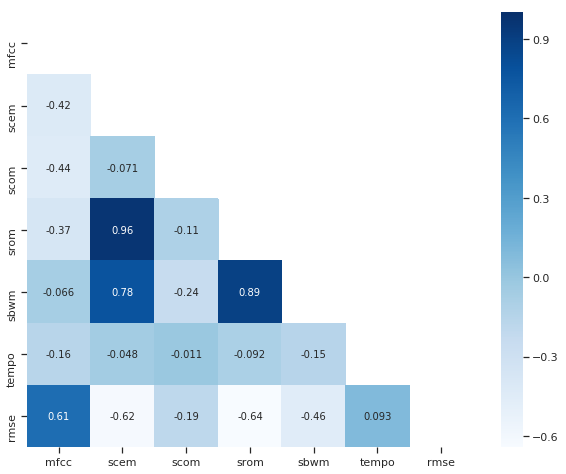

In [71]:
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(data.corr(), mask=mask, annot=True, cmap="Blues")

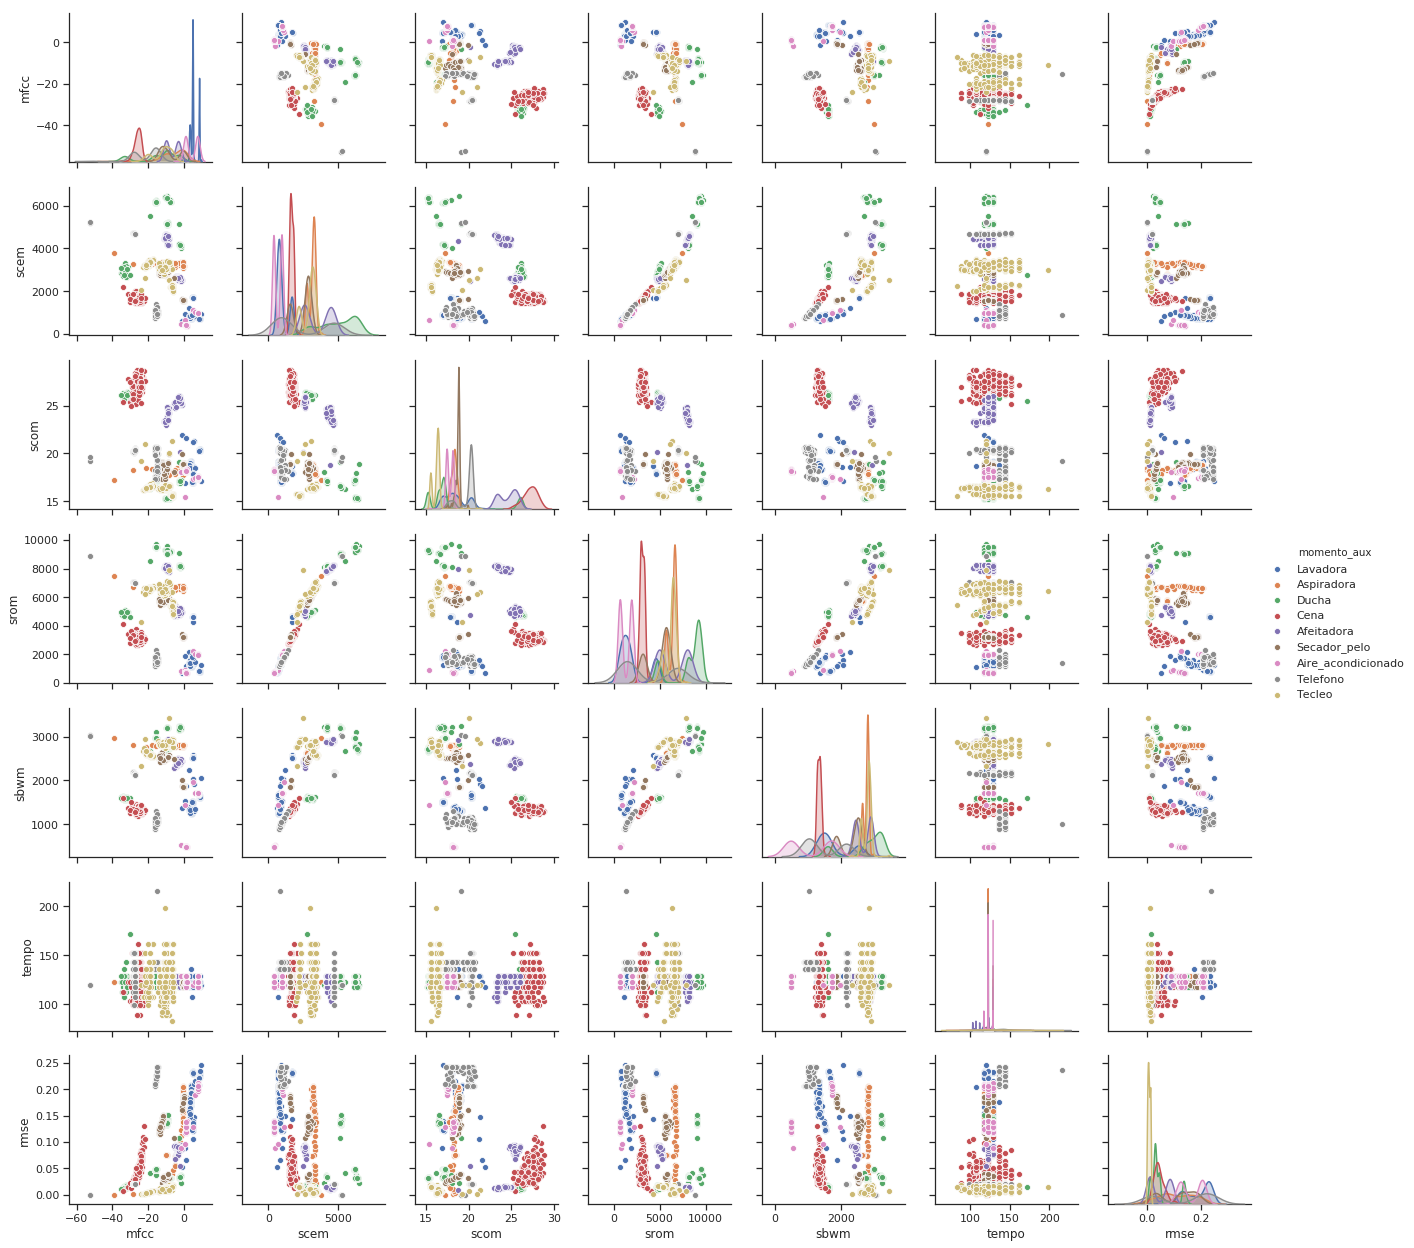

In [72]:
sns.set(style="ticks")

sns.pairplot(data, hue="momento_aux")

In [73]:
y = pd.get_dummies(data=data.momento_aux)
X = data.loc[:, data.columns != 'momento_aux']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [74]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
scores = cross_val_score(clf, X, y, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[1.         0.95454545 0.97385621 0.98039216 1.         0.94771242
 0.9869281  0.9869281  0.96078431 0.03267974]
Accuracy: 0.88 (+/- 0.57)


In [75]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9804560260586319

In [76]:
predictions = clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.00
Aire_acondicionado    0.00
Aspiradora            0.00
Cena                  0.00
Ducha                 0.01
Lavadora              0.00
Secador_pelo          0.00
Tecleo                0.00
Telefono              0.00
dtype: float64 degrees.


In [77]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)
cls.fit(X_train, y_train)
importances = cls.feature_importances_

In [78]:
std = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)

In [79]:
indices = np.argsort(importances)[::-1]

In [80]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

display(pd.DataFrame(cls.feature_importances_, 
                     index = X_train.columns, 
                     columns = ['importance']).sort_values('importance', ascending=False))

Feature ranking:
1. feature 4 (0.187675)
2. feature 0 (0.172533)
3. feature 2 (0.172229)
4. feature 3 (0.157363)
5. feature 1 (0.151311)
6. feature 6 (0.132963)
7. feature 5 (0.025926)


,importance
sbwm,0.187675
mfcc,0.172533
scom,0.172229
srom,0.157363
scem,0.151311
rmse,0.132963
tempo,0.025926


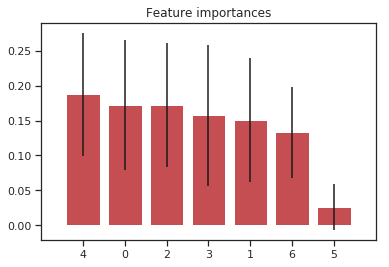

In [81]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [82]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9837133550488599

In [83]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9800324675324674

In [84]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo']
precision_recall.index.name = 'momento_aux'
precision_recall

,precision,recall,f1_score
momento_aux,,,
Cena,0.878788,1.000000,0.935484
Ducha,1.000000,1.000000,1.000000
Lavadora,1.000000,0.933333,0.965517
Aspiradora,1.000000,0.966667,0.983051
Afeitadora,0.969697,0.969697,0.969697
Secador_pelo,1.000000,1.000000,1.000000
Aire_acondicionado,1.000000,0.971429,0.985507
Telefono,1.000000,0.979167,0.989474
Tecleo,1.000000,1.000000,1.000000


Confusion matrix, without normalization
[[29  0  0  0  0  0  0  0  0]
 [ 0 29  0  0  0  0  0  0  0]
 [ 1  0 14  0  0  0  0  0  0]
 [ 0  0  0 29  1  0  0  0  0]
 [ 1  0  0  0 32  0  0  0  0]
 [ 0  0  0  0  0 51  0  0  0]
 [ 1  0  0  0  0  0 34  0  0]
 [ 1  0  0  0  0  0  0 47  0]
 [ 0  0  0  0  0  0  0  0 37]]


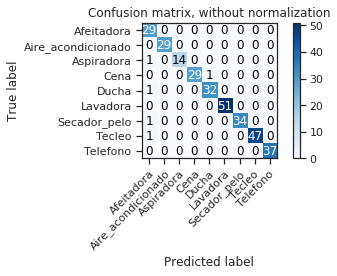

In [85]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [86]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo'])
n_classes = y.shape[1]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [88]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [89]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [90]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [91]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [92]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [93]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

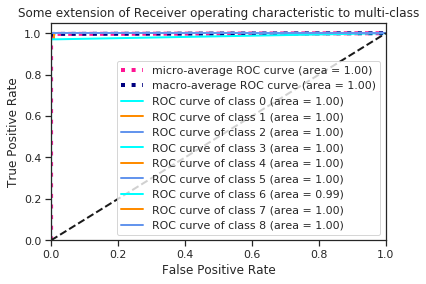

In [94]:
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()